In [1]:
%gui wx

%load_ext autoreload
%autoreload 2
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"
#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import nilearn
#from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
#from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
import subprocess
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report # not all used


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Gtk-Message: 09:37:34.042: Failed to load module "canberra-gtk-module"


In [2]:
current_dir = os.path.abspath("")
#print(f"current_dir: {current_dir}")
sys.path.append(current_dir)

dataset_id = 'ds000171'
subjects = ['sub-control{:02d}'.format(i+1) for i in range(20)]

dataset_path = os.path.join(current_dir, "data", dataset_id)
deriv_path = os.path.join(current_dir,"data", "derivatives")
preproc_path = os.path.join(deriv_path, 'preprocessed_data')

subject = "sub-control01"
task = 'music'
mkdir_no_exist(dataset_path)
mkdir_no_exist(preproc_path)

In [3]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

09:37:54: Debug: Adding duplicate image handler for 'Windows bitmap file'
09:37:54: Debug: Adding duplicate animation handler for '1' type
09:37:54: Debug: Adding duplicate animation handler for '2' type
09:37:54: Debug: Adding duplicate image handler for 'Windows bitmap file'
09:37:54: Debug: Adding duplicate animation handler for '1' type
09:37:54: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:618): Gtk-CRITICAL **: 09:37:55.221: gtk_window_resize: assertion 'height > 0' failed
09:37:56: Debug: ScreenToClient cannot work when toplevel window is not shown
09:37:56: Debug: ScreenToClient cannot work when toplevel window is not shown
09:37:56: Debug: ScreenToClient cannot work when toplevel window is not shown
09:37:56: Debug: ScreenToClient cannot work when toplevel window is not shown
09:37:56: Debug: ScreenToClient cannot work when toplevel window is not shown
09:37:56: Debug: ScreenToClient cannot work when toplevel window is not shown
09:37:56: Debu

### Overview of the brain before any preprocessing

In [4]:
# all paths from anatomical preprocessing
anatomical_path = '/data/data/ds000171/sub-control01/anat/sub-control01_T1w.nii.gz'
resulting_mask = '/data/data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask.nii.gz'
betted_brain_path = '/data/data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w.nii.gz'
segmentation_path  = '/data/data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast'
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
t1w_mni = '/data/data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mni_SyN.nii.gz'

In [ ]:
anatomical_path = op.join(dataset_path, subject, 'anat', '{}_T1w.nii.gz').format(subject)
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anatomical_path)

# 1. Skull Removal and fast tissue segmentation

In [ ]:
from preprocessed import get_skull_stripped_anatomical

resulting_mask = get_skull_stripped_anatomical(dataset_path, preproc_path, subject, robust=True)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(dataset_path, subject, 'anat', '{}_T1w.nii.gz').format(subject))
fsleyesDisplay.load(resulting_mask)

In [ ]:
# The brain without skull is in the derivatives folder
from preprocessed import apply_fsl_mask

betted_brain_path = apply_fsl_mask(dataset_path, resulting_mask, preproc_path, subject)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

In [ ]:
#TODO discuss segmentation

In [ ]:
from preprocessed import apply_fast
segmentation_path = apply_fast(preproc_path, subject)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_path, subject, 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_path, subject, 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_path, subject, 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## Linear normalization using Ants
Using advanced normalization tools (ANTS), we standardize the fMRI to a standard, to be able to do comparisons.

In [ ]:
%autoreload 3

In [ ]:
from preprocessed import apply_ants
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
t1w_mni = apply_ants(preproc_path, subject, mni_template)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(mni_template)
fsleyesDisplay.load(t1w_mni)

## Field Stabilisation
Field Stabilisation doesn't seem necessary

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load("/data/data/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz").get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

##### Quality control passed for anatomical preprocessing !

# fMRI Preprocessing

In [5]:
#paths for fMRI preprocessing
all_runs = os.path.join(preproc_path, subject, 'func', '{}_task-{}_run-{}_bold'.format(subject, task, 'all'))
path_moco_data = './data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco.nii.gz'
epi_reg_path = './data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_anat-space_epi.nii.gz'
splits_path = op.join(preproc_path, subject, 'func','splits')
split_vols = sorted(glob.glob(op.join(splits_path, '*_bold_split*')))

In [ ]:
#Marianne and Gregor please run this cell

#merging the runs
runs = []
bids_root = dataset_path
for i in range(3):
    run = os.path.join(bids_root, subject, 'func', '{}_task-{}_run-{}_bold'.format(subject, task, i+1))
    runs.append(run)
    
all_runs = os.path.join(preproc_path, subject, 'func', '{}_task-{}_run-{}_bold'.format(subject, task, 'all'))
subprocess.run(['fslmerge', '-t', all_runs, runs[0], runs[1], runs[2]])

#applying motion correction

from preprocessed import apply_mcflirt
task = 'music'
run = 'all'
path_moco_data, reference_moco = apply_mcflirt(preproc_path, preproc_path, subject, task, run) # twice preproc_path since we start from 'all'

voxel_smooth = 6

mkdir_no_exist(op.join(preproc_path, subject, 'func', 'final'))
output_path = op.join(preproc_path, subject, 'func', 'final','sub-control01_task-music_run-all_bold_NoStd') 
subprocess.run(['fslmaths',path_moco_data, '-s', str(voxel_smooth/2.3548), '{}_smoothed-6mm'.format(output_path)])


In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path+'_smoothed-6mm')

## Standardization and run concatenation

In [5]:
from preprocessed import concatenate_mri_runs

all_runs = os.path.join(preproc_path, subject, 'func', '{}_task-{}_run-{}_bold.nii.gz'.format(subject, task, 'all'))
concatenate_mri_runs(dataset_path, subject, task, all_runs)

Shape of the series of volumes of run 0: (80, 80, 50, 105)
Shape of the series of volumes of run 1: (80, 80, 50, 105)
Shape of the series of volumes of run 2: (80, 80, 50, 105)
Concatenation complete. Output saved to /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold.nii.gz


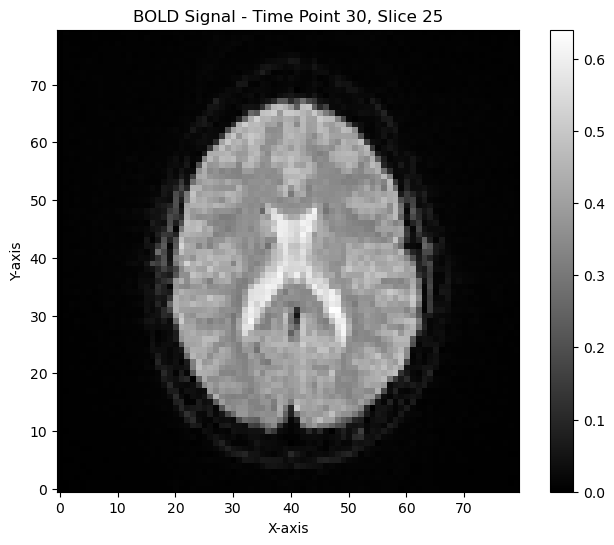

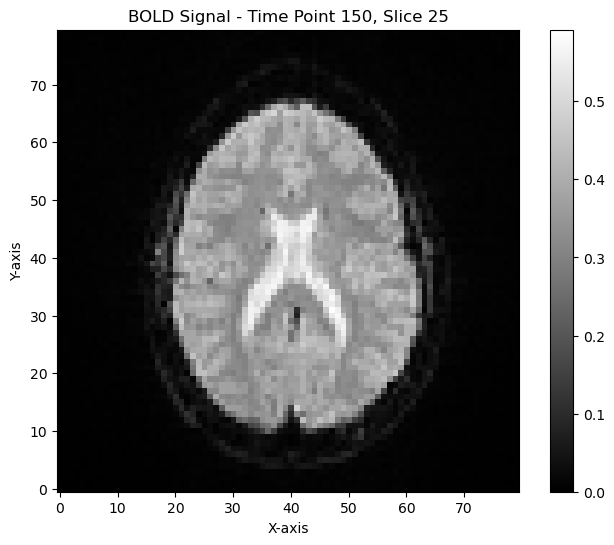

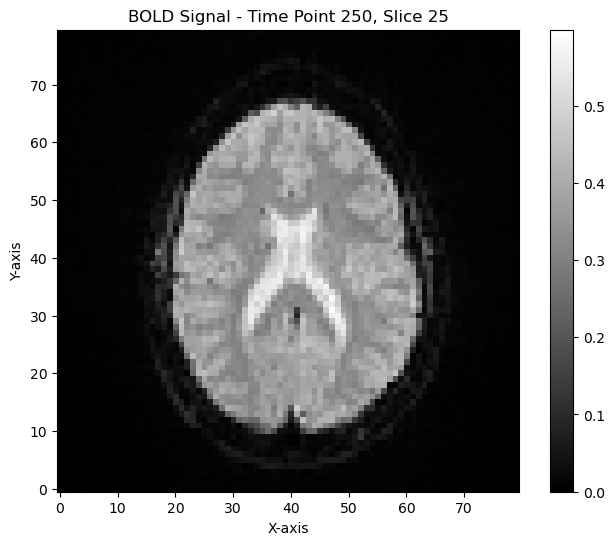

In [9]:
from preprocessed import plot_bold_data, plot_mean_voxel_intensity

plot_bold_data(all_runs, timepoints=[30,150,250])

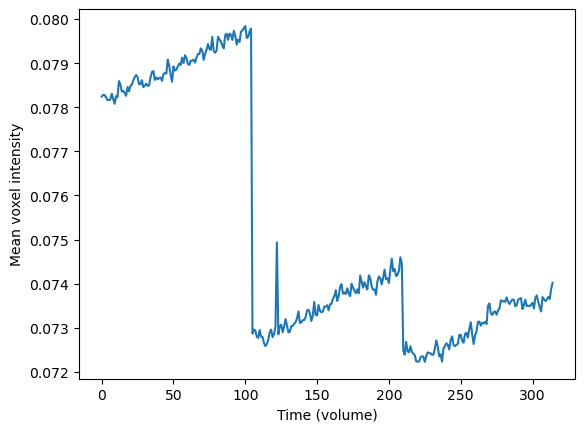

In [10]:
plot_mean_voxel_intensity(all_runs)

In [85]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(all_runs)

## Motion correction

In [25]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)
fsleyesDisplay.load(reference_moco)

In [24]:
from preprocessed import apply_mcflirt
task = 'music'
run = 'all'
path_moco_data, reference_moco = apply_mcflirt(preproc_path, preproc_path, subject, task, run) # twice preproc_path since we start from 'all'

Processed data will be saved as /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [-1] to 8 mm pixels
Registering volumes ... [0][1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158

In [73]:
# There are basically (if looking only along X translation) no frame displacement above 0.2mm!
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_path, subject, 'func', '{}_task-{}_run-{}_bold_moco.par'.format(subject, task, "all")))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.001053,0.004410,0.000562,-0.180012,-0.127666,0.034306
1,0.000186,0.005399,-0.003226,-0.009129,-0.309941,0.073895
2,0.001239,0.004707,0.002436,-0.397055,-0.214057,0.096358
3,-0.001165,0.004617,-0.000045,-0.303831,-0.261383,-0.148797
4,0.001612,0.005942,-0.003686,-0.118599,0.048404,-0.025121
...,...,...,...,...,...,...
310,-2.935120,0.184533,-0.053612,-3.644160,-6.518880,6.518810
311,-2.894890,0.233417,-0.098092,-2.168940,-5.732380,6.209710
312,-2.967670,0.209833,-0.083656,-3.678020,-5.157720,5.672980
313,-2.885480,0.261556,-0.096015,-0.819498,-6.489420,4.396590


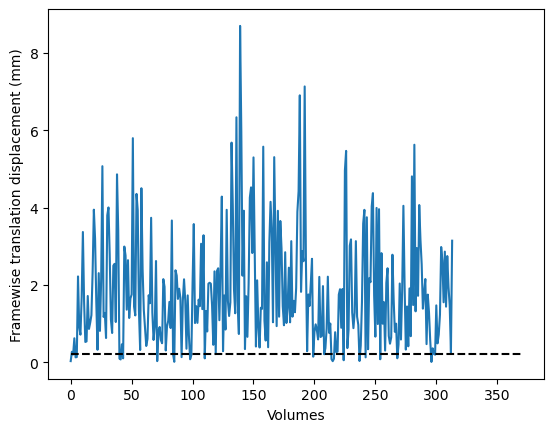

In [74]:
import numpy as np
# write your code here to inspect quickly the translation on X :)
#%matplotlib inline

# Getting the translation is easy
trans = mot_params["Translation x"] + mot_params["Translation y"] + mot_params["Translation z"]
# Now, we want a 0.2mm with respect to previous frame:
disp = np.diff(trans)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()


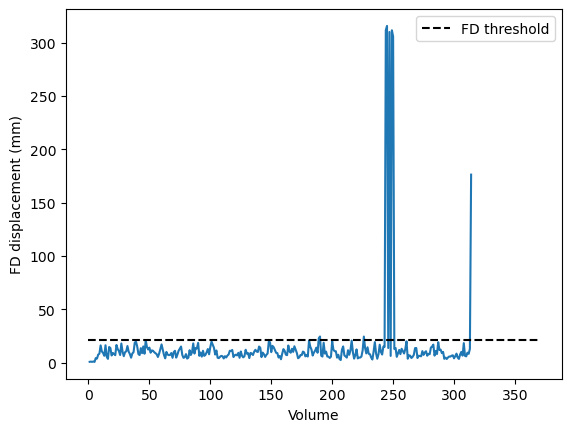

In [75]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [ ]:
#TODO manually correcting voxels outside of the brain that are active
black_value = 0.0005
#whole plane at time point 122
# For now just discard that one

## Epi to anatomical coregistration (very lengthy - do not run => jump to slice timing and smoothing)

Checks for this part 

- Is the functional in the right orientation?
- Are the ventricles correctly aligned?
- Are the boundaries of the EPI more or less matching the anatomical?
- Applying ONLY motion correction transformation to the first volume yields the expected alignement (so it should be aligned with the \_moco volume.)
- Applying motion correction + epi -> anat should be aligned to anatomical
- Finally, applying motion correction + epi > anat + anat > standard should be aligned to the standard

In [26]:
from preprocessed import apply_epi_reg
epi_reg_path, reference_epi = apply_epi_reg(dataset_path, preproc_path, path_moco_data, subject, task, 'all')
# We did the coregistration of the reference volume and get a transform, now we need to apply it to all volumes
#Alternative: use mcflirt with the -meanvol option and then use the mean functional volume as input to  epi_reg.

FLIRT pre-alignment
Running BBR
0.290853 0.999457 -0.032920 -0.001468 0.000000 0.032927 0.999447 0.004659 0.000000 0.001313 -0.004705 0.999988 0.000000 -4.405679 7.810441 -0.580121 1.000000 
Done with EPI to anatomical registration


In [35]:
# Inspect here if transformations worked
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('./data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_anat-space_epi_fast_wmseg.nii.gz')
fsleyesDisplay.load('./data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2')
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'

In [34]:
#check how the white matter of the EPI matches your anatomical's white matter provided you have sufficient resolution
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(epi_reg_path)

In [ ]:
# apply the transformation to all volumes - does not work
"""all_epi = epi_reg_path+'_4d'

#This should work with one transform for all volumes but apparently he wants one mat file per volume
result = subprocess.run(['applyxfm4D', path_moco_data, anatomical_path, all_epi,path_epi_transform]) #, '-userprefix', ''

#Alternative that does not work neither
subprocess.run(['flirt', '-in', path_moco_data, '-ref', anatomical_path,'-out', all_epi, '-init', path_epi_transform,'-applyxfm'])"""

In [6]:
# We split the volumes to later apply epi_reg one by one
path_epi_transform = op.join(preproc_path, subject, 'func/sub-control01_task-music_run-all_bold_anat-space_epi.mat')
split_target = path_moco_data
splits_path = op.join(preproc_path, subject, 'func','splits')
mkdir_no_exist(splits_path)
split_name = op.join(splits_path, 'sub-control01_task-music_run-all_bold_split')

#subprocess.run(['fslsplit', split_target, split_name, '-t'])

#### Apply the trasnformation to each volume independently 

In [30]:
split_vols = sorted(glob.glob(op.join(splits_path, '*_bold_split*')))
splits_epi_path = op.join(preproc_path, subject, 'func','splits_epi')
mkdir_no_exist(splits_epi_path)
for i,split_vol in enumerate(split_vols[79:]): 
    split_nbr = split_vol.split('_')[-1].split('.')[0].split('split')[1]
    out_vol= op.join(preproc_path, subject, 'func', 'splits_epi','sub-control01_task-music_run-all_bold_epi_vol' + split_nbr)
    subprocess.run(['flirt', '-in', split_vol, '-ref', anatomical_path,'-out', out_vol,
                        '-init', path_epi_transform,'-applyxfm'])

In [ ]:
os.system('rm -rf {}'.format(op.join(splits_path, '*_bold_split*')))

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(split_vols[0])
fsleyesDisplay.load(split_vols[10])
fsleyesDisplay.load(split_vols[20])

#### Combining runs together

In [ ]:
from preprocessed import combine_runs
combine_runs(preproc_path, splits_epi_path, subject)

In [ ]:
import progressbar
import gc
split_vols_epi = sorted(glob.glob(op.join(splits_epi_path, '*_bold_epi*')))

first_vol = nib.load(split_vols_epi[0])
v_shape = first_vol.get_fdata().shape
'{}_task-{}_run-{}_bold_moco'
filename = op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_epi_concat.dat')
large_array = np.memmap(filename, dtype=np.float64, mode='w+', shape=(v_shape[0],v_shape[1],v_shape[2], len(split_vols_epi)))

batch_size = len(split_vols_epi)//4

A = np.zeros((v_shape[0],v_shape[1],v_shape[2], batch_size))

with progressbar.ProgressBar(max_value=len(split_vols_epi)) as bar:
    for batch_i in range(4):
        print('Starting for batch {}/4'.format(batch_i+1))
        start_batch = batch_size * batch_i
        end_batch = min(batch_size * (batch_i+1),len(split_vols_epi))
        max_len = end_batch - start_batch + 1
        for i in range(start_batch, end_batch):
            vol = nib.load(split_vols_epi[i])
            A[:,:,:,i-start_batch] = vol.get_fdata()
            bar.update(i)
        large_array[:,:,:, start_batch:end_batch] = A[:,:,:,:max_len]
        gc.collect()

In [ ]:
#large_array.flush()
#del large_array
print("Done flushing mmap")
large_array = np.memmap(filename, dtype=np.float64, mode='r', shape=(v_shape[0],v_shape[1],v_shape[2], len(produced_vols)))

# Step 2: Modify the header to indicate that we have 4D data, and specify its TR.
header = first_vol.header.copy()  # Copy the header of the first volume (to get right resolution, affine, Q-form etc)
header['dim'][0] = 4  # Specifies that this is a 4D dataset
header['dim'][1:5] = large_array.shape  # Update dimensions (x, y, z, t)
header['pixdim'][4] = 1.5  # Set the TR in the 4th dimension. You can see the TR of the data by looking at your original EPI series with fslhd, remember ;)
print("Done with header")

# Step 3: Create the Nifti1 image and save it to disk
mni_epi = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_mni.nii.gz')
img = nib.Nifti1Image(large_array, first_vol.affine, first_vol.header)
print("Done creating the image")
img.to_filename(mni_epi)
print("Done writing it to disk")

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(mni_template)
fsleyesDisplay.load(split_vols_epi[0])

## Slice Time correction

In [56]:
task='music'
data = pd.read_json(op.join(dataset_path, 'task-{}_bold.json'.format(task)), typ= 'series')
slice_timing = data['SliceTiming']
tr = data['RepetitionTime'] 

In [57]:
# get the informations in the header - to determine the number of slices
os.system('fslhd {}'.format(op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_moco.nii.gz')))

filename	/data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco.nii.gz

sizeof_hdr	348
data_type	FLOAT64
dim0		4
dim1		80
dim2		80
dim3		50
dim4		315
dim5		1
dim6		1
dim7		1
vox_units	mm
time_units	s
datatype	64
nbyper		8
bitpix		64
pixdim0		-1.000000
pixdim1		2.900000
pixdim2		2.900000
pixdim3		3.000000
pixdim4		1.000000
pixdim5		1.000000
pixdim6		1.000000
pixdim7		1.000000
vox_offset	352
cal_max		0.981631
cal_min		0.000000
scl_slope	1.000000
scl_inter	0.000000
phase_dim	0
freq_dim	0
slice_dim	0
slice_name	Unknown
slice_code	0
slice_start	0
slice_end	0
slice_duration	0.000000
toffset		0.000000
intent		Unknown
intent_code	0
intent_name	
intent_p1	0.000000
intent_p2	0.000000
intent_p3	0.000000
qform_name	Unknown
qform_code	0
qto_xyz:1	-2.898233 0.000000 0.104700 118.931046 
qto_xyz:2	-0.065056 2.221529 -1.927188 -77.453430 
qto_xyz:3	0.077531 1.864084 2.296733 -140.277512 
qto_xyz:4	0.000000 0.000000 0.000000 1.000000 
qform_xorient	Right-

0

In [49]:
len(slice_timing) #check which dimensions has the slices # here it is the z dimension so we give "-d 3" to slicetimer below 

50

In [58]:
slice_order = np.argsort(slice_timing) + 1

# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_path, subject, 'func', 'sub-001_task-music_run-1_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:
    file.write(str(t) + '\n')
file.close()

In [59]:
file_to_realign = op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_moco.nii.gz')
slice_corrected = op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_slice-corr')

subprocess.run(['slicetimer', '-i', file_to_realign, '-o', slice_corrected, '-r', str(tr), '-d', str(3), '--ocustom={}'.format(timing_path)]) #os.system('slicetimer')

CompletedProcess(args=['slicetimer', '-i', '/data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco.nii.gz', '-o', '/data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_slice-corr', '-r', '3.0', '-d', '3', '--ocustom=/data/data/derivatives/preprocessed_data/sub-control01/func/sub-001_task-music_run-1_slice-timings.txt'], returncode=0)

In [60]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(slice_corrected)

In [ ]:
split_target = original_epi
split_name = op.join(preproc_path, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_split')

subprocess.run(['fslsplit', split_target, split_name, '-t'])
print_dir_tree(bids_root,max_depth=5)

In [ ]:
# Let's combine the different transforms EXCEPT motion correction!
warp_name = op.join(preproc_path, 'sub-001', 'func', 'sub-001_epi_moco_2_std_warp')

print("Starting to combine transforms...")
#combine_all_transforms(ref, warp_name,  True, epi_2_moco=None, epi_2_anat_warp=func_2_anat, anat_2_standard_warp=anat_2_mni_trans)
print("Done, moving on to application of transforms...")

###########
# Now apply transformation to all our volumes.
# We will remember the volumes as well, to group them back afterwards.
##########

# Notice that we are sorting the volumes here! This is important, to make sure we don't get them in random order :)
split_vols = sorted(glob.glob(op.join(preproc_path, subject, 'func', '*_bold_split*')))


# Define a function that wraps subprocess.run()
def run_subprocess(split_vol, vol_nbr):
    """
    SAFETY GOGGLES ON
    This function launches applywarp in parallel to reach complete result quicker

    Parameters
    -----------
    split_vol: str
        Path to the volume on which to apply the transformation
    vol_nbr: str
        Number of the volume in the timeserie. Useful to reorder volumes after the fact, since parallelisation does not honour order.

    Returns
    -------
    out_vol: str
        Path to the transformed volume
    vol_nbr: str
        Number of the volume in the timeserie. Useful to reorder volumes after the fact.
    """
    try:
        split_nbr = split_vol.split('_')[-1].split('.')[0].split('split')[1]
        epi_moco = op.join(preproc_path, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_moco.mat/', 'MAT_' + split_nbr)
        out_vol= op.join(preproc_path, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_std_vol' + split_nbr)
        result = subprocess.run(['applywarp', '-i', split_vol, '-r', ref, '-o', out_vol, '-w', warp_name, '--abs', '--premat={}'.format(epi_moco)], check=True)
        return out_vol, vol_nbr
    except subprocess.CalledProcessError as e:
        return f"applywarp for volume '{split_vol}' failed with error: {e.stderr.decode('utf-8')}"


produced_vols = [None]*len(split_vols)
# Initialize ThreadPoolExecutor and the progress bar
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use tqdm to wrap the futures
    with tqdm(total=len(split_vols)) as progress:
        # Launch subprocesses in parallel
        futures = {executor.submit(run_subprocess, vol,i): vol for i,vol in enumerate(split_vols)}

        # Process completed tasks
        for future in concurrent.futures.as_completed(futures):
            out_vol, vol_nbr = future.result()  # Get the result of the subprocess
            produced_vols[vol_nbr] = out_vol
            # Update the progress bar for each completed task
            progress.update(1)

## Smoothing

In [64]:
mkdir_no_exist(op.join(preproc_path, subject, 'func', 'final'))
smooth_voxel = 5 #mm
output_path = op.join(preproc_path, subject, 'func', 'final','sub-control01_task-music_run-all_bold') 
subprocess.run(['fslmaths',path_moco_data, '-s', str(smooth_voxel/2.3548), '{}_smoothed-{}mm'.format(output_path, smooth_voxel)])

CompletedProcess(args=['fslmaths', './data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco.nii.gz', '-s', '2.123322575165619', '/data/data/derivatives/preprocessed_data/sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-5mm'], returncode=0)

In [63]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('./data/derivatives/preprocessed_data/sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-5mm.nii.gz')